<a href="https://colab.research.google.com/github/tonigarrett2023/FinalProject/blob/main/concatenated_datasets_4th_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf


from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import shutil
from shutil import copyfile
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from sklearn.preprocessing import LabelEncoder

from scipy.ndimage import map_coordinates
import math



In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Define paths for the two datasets where dataset1 is Hyperkvasir and dataset2 is CrohnIPI
dataset1_path = "/content/drive/MyDrive/Final_Project/Hyperkvasir_labeled_images/upper_lower_gi_tract"
dataset1_csv = "/content/drive/MyDrive/Final_Project/Hyperkvasir_labeled_images/image-labels.csv"

dataset2_path = '/content/drive/MyDrive/Final_Project/DataCrohnIPI/imgs'
dataset2_csv = '/content/drive/MyDrive/Final_Project/DataCrohnIPI/CrohnIPI_description.csv'

the two datasets are loaded into dataframes using the pd.read_csv function.

In [ ]:
# Load the CSV files into dataframes for each dataset
dataset1_labels = pd.read_csv(dataset1_csv)
dataset2_labels = pd.read_csv(dataset2_csv)

Inspect the dataframes for each of these datasets

In [ ]:
dataset1_labels

Video file     Organ          Finding  \
0      000e3fee-7f5c-4819-9f9c-4c983b68888a  Lower GI            cecum   
1      001a41c2-2a5d-40b1-8fd5-b5f2f292277b  Lower GI            cecum   
2      006af0aa-2044-4477-964d-10d9e043fb78  Lower GI            cecum   
3      00832522-ab8e-4b98-bfce-93a777929571  Lower GI            cecum   
4      012ab888-64e6-4361-9745-f52b4a03ba75  Lower GI            cecum   
...                                     ...       ...              ...   
10657  f7dd198b-88f0-4566-b8f4-81c8c2fee1ed  Upper GI  esophagitis-b-d   
10658  f9a06ca3-3500-4e5e-ac46-110b52963a99  Upper GI  esophagitis-b-d   
10659  fb31e2c2-c8db-42b3-bbf1-564e42076a8e  Upper GI  esophagitis-b-d   
10660  fe6c191e-3da0-4f18-9e38-8f7a11097a3b  Upper GI  esophagitis-b-d   
10661  ff4f2ed2-69a8-455d-894a-8d536b324653  Upper GI  esophagitis-b-d   

              Classification  
0       anatomical-landmarks  
1       anatomical-landmarks  
2       anatomical-landmarks  
3       anatomical-landmarks  
4       anatomical-landmarks  
...                      ...  
10657  pathological-findings  
10658  pathological-findings  
10659  pathological-findings  
10660  pathological-findings  
10661  pathological-findings  

[10662 rows x 4 columns]

In [ ]:
dataset2_labels

Framename  Label  Fold
0     00001.jpg      N     2
1     00002.jpg      N     4
2     00003.jpg      N     1
3     00004.jpg      N     4
4     00005.jpg      N     3
...         ...    ...   ...
3479  03494.jpg      N     3
3480  03495.jpg      E     4
3481  03496.jpg      N     1
3482  03497.jpg  U3-10     3
3483  03498.jpg      N     5

[3484 rows x 3 columns]

In [ ]:
# Rename the columns to the standard column names
dataset1_labels = dataset1_labels.rename(columns={"Video file": "filename", "Finding": "label"})
dataset2_labels = dataset2_labels.rename(columns={"Framename": "filename", "Label": "label"})

In [ ]:
# Create a dictionary that maps each label to a description
label_map = {
    "E": "Erythema",
    "O": "Oedema",
    "AU": "Aphthoid ulceration",
    "U3-10": "Ulceration between 3mm and 10mm",
    "U>10": "Ulceration over 10mm",
    "S": "Stenosis",
    "N": "Normal"
}

# Replace the label values in the DataFrame with the corresponding descriptions
dataset2_labels["label"] = dataset2_labels["label"].replace(label_map)

Inspect again to check to see if the labels in dataset2 now have their full names listed instead of abbreviations and if the column names have been changed

In [ ]:
dataset2_labels

filename                            label  Fold
0     00001.jpg                           Normal     2
1     00002.jpg                           Normal     4
2     00003.jpg                           Normal     1
3     00004.jpg                           Normal     4
4     00005.jpg                           Normal     3
...         ...                              ...   ...
3479  03494.jpg                           Normal     3
3480  03495.jpg                         Erythema     4
3481  03496.jpg                           Normal     1
3482  03497.jpg  Ulceration between 3mm and 10mm     3
3483  03498.jpg                           Normal     5

[3484 rows x 3 columns]

np.unique is used to get the unique classes from the labels in each dataset. For crohns_classes, we select only the rows where the class column is not equal to 'normal'. For normal_classes, we select only the rows where the class column is equal to 'normal' and extract the unique values from the normal column. For uc_classes, we select only the rows where the class column starts with 'ulcerative'.

And check again. 

In [ ]:
# Get the unique classes from the labels in each dataset
crohns_classes = np.unique(dataset2_labels[dataset2_labels['label'] != 'Normal']['label'])
normal_classes = np.unique(dataset2_labels[dataset2_labels['label'] == 'Normal']['label'])
uc_classes = np.unique(dataset1_labels[dataset1_labels['label'].str.startswith('ulcerative')]['label'])


In [ ]:
print(crohns_classes)

['Aphthoid ulceration' 'Erythema' 'Oedema' 'Stenosis'
 'Ulceration between 3mm and 10mm' 'Ulceration over 10mm']


In [ ]:
print(normal_classes)

['Normal']


In [ ]:
print(uc_classes)

['ulcerative-colitis-grade-0-1' 'ulcerative-colitis-grade-1'
 'ulcerative-colitis-grade-1-2' 'ulcerative-colitis-grade-2'
 'ulcerative-colitis-grade-2-3' 'ulcerative-colitis-grade-3']


Now we concatenate the 2 dataframes into a merged_labels dataframe 

In [ ]:
# Concatenate the labels from each dataset
merged_labels = pd.concat([dataset1_labels[dataset1_labels['label'].isin(uc_classes) | dataset1_labels['label'].isin(normal_classes)], 
                           dataset2_labels[dataset2_labels['label'].isin(crohns_classes) | dataset2_labels['label'].isin(normal_classes)]], 
                          ignore_index=True)


In [ ]:
merged_labels

filename     Organ  \
0     1fda887e-e41c-4879-8581-3b3668da4ae2  Lower GI   
1     24ea5882-2bce-47fc-819b-96f999be2d55  Lower GI   
2     2a93d2af-50a8-4459-9d4b-5420a6f29a86  Lower GI   
3     34c36057-d7a9-4862-a599-41f764532bd2  Lower GI   
4     35f3d21d-def1-4bec-a96e-9a3906a3de78  Lower GI   
...                                    ...       ...   
4330                             03494.jpg       NaN   
4331                             03495.jpg       NaN   
4332                             03496.jpg       NaN   
4333                             03497.jpg       NaN   
4334                             03498.jpg       NaN   

                                label         Classification  Fold  
0        ulcerative-colitis-grade-0-1  pathological-findings   NaN  
1        ulcerative-colitis-grade-0-1  pathological-findings   NaN  
2        ulcerative-colitis-grade-0-1  pathological-findings   NaN  
3        ulcerative-colitis-grade-0-1  pathological-findings   NaN  
4        ulcerative-colitis-grade-0-1  pathological-findings   NaN  
...                               ...                    ...   ...  
4330                           Normal                    NaN   3.0  
4331                         Erythema                    NaN   4.0  
4332                           Normal                    NaN   1.0  
4333  Ulceration between 3mm and 10mm                    NaN   3.0  
4334                           Normal                    NaN   5.0  

[4335 rows x 5 columns]

The labels for Crohn's disease, ulcerative colitis, and normal are grouped separately using the isin method, and the normal column is added to the merged labels dataframe.

In [ ]:
# Group the labels for Crohn's disease, ulcerative colitis, and normal
merged_labels['crohns'] = merged_labels['label'].isin(crohns_classes).astype(int)
merged_labels['uc'] = merged_labels['label'].apply(lambda x: x.startswith('ulcerative-colitis')).astype(int)
merged_labels['normal'] = merged_labels['label'].isin(normal_classes).astype(int)



In [ ]:
# Convert the labels to numpy arrays
labels = merged_labels[['crohns', 'uc', 'normal']].to_numpy()

There should now be extra columns in the merged_labels df indicating which filename belongs to which class. 

Merged_labels df will only consist of the 3 classes we want to classify: Crohns, Ulcerative Colitis or Normal

In [ ]:
merged_labels

filename     Organ  \
0     1fda887e-e41c-4879-8581-3b3668da4ae2  Lower GI   
1     24ea5882-2bce-47fc-819b-96f999be2d55  Lower GI   
2     2a93d2af-50a8-4459-9d4b-5420a6f29a86  Lower GI   
3     34c36057-d7a9-4862-a599-41f764532bd2  Lower GI   
4     35f3d21d-def1-4bec-a96e-9a3906a3de78  Lower GI   
...                                    ...       ...   
4330                             03494.jpg       NaN   
4331                             03495.jpg       NaN   
4332                             03496.jpg       NaN   
4333                             03497.jpg       NaN   
4334                             03498.jpg       NaN   

                                label         Classification  Fold  crohns  \
0        ulcerative-colitis-grade-0-1  pathological-findings   NaN       0   
1        ulcerative-colitis-grade-0-1  pathological-findings   NaN       0   
2        ulcerative-colitis-grade-0-1  pathological-findings   NaN       0   
3        ulcerative-colitis-grade-0-1  pathological-findings   NaN       0   
4        ulcerative-colitis-grade-0-1  pathological-findings   NaN       0   
...                               ...                    ...   ...     ...   
4330                           Normal                    NaN   3.0       0   
4331                         Erythema                    NaN   4.0       1   
4332                           Normal                    NaN   1.0       0   
4333  Ulceration between 3mm and 10mm                    NaN   3.0       1   
4334                           Normal                    NaN   5.0       0   

      uc  normal  
0      1       0  
1      1       0  
2      1       0  
3      1       0  
4      1       0  
...   ..     ...  
4330   0       1  
4331   0       0  
4332   0       1  
4333   0       0  
4334   0       1  

[4335 rows x 8 columns]

In [ ]:
# save dataframe to CSV file
path = '/content/drive/MyDrive/Final_Project/merged_labels.csv'
merged_labels.to_csv(path, index=False)

The image folders should be created for the entire dataset, not just for the merged_labels. The idea behind creating separate folders for each class is to organize the images in a way that makes it easier to load them into memory and use them for model training.


In [ ]:
# Define constants for merged datasets
merged_dir = '/content/drive/MyDrive/Final_Project/merged_dir'

# Create merged directory
os.makedirs(merged_dir, exist_ok=True)

In [ ]:
# Copy images from HyperKvasir dataset to merged directory
# Define the list of class names for dataset1/HyperKvasir
class_names = ['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1',
               'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps',
               'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum',
               'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus',
               'z-line', 'retroflex-stomach']

# Loop over the class names and copy the image files to the merged directory
for class_name in class_names:
    # Define the source and destination directories for the class
    src_dir = os.path.join(dataset1_path, class_name)
    dst_dir = os.path.join(merged_dir, class_name)
    os.makedirs(dst_dir, exist_ok=True)

    # Loop over the image files in the source directory and copy them to the destination directory
    for filename in os.listdir(src_dir):
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)
        shutil.copyfile(src_path, os.path.join(dst_dir, f"{class_name}_{filename}"))

OSError: ignored

In [ ]:
# Copy images from CrohnsIPI dataset to merged directory
# Loop over the images in the dataset2 directory and move them to the corresponding class folders
class_names = ['Aphthoid ulceration', 'Erythema', 'Oedema', 'Stenosis',
               'Ulceration between 3mm and 10mm', 'Ulceration over 10mm', 'Normal']

# Create the class folders in the merged directory
for class_name in class_names:
    os.makedirs(os.path.join(merged_dir, class_name), exist_ok=True)

# Loop over the rows in the dataframe and move the corresponding image file to the class folder in the merged directory
for index, row in dataset2_labels.iterrows():
    filename = row['filename']
    label = row['label']
    src_path = os.path.join(dataset2_path, filename)
    dst_path = os.path.join(merged_dir, label, filename)
    shutil.copyfile(src_path, os.path.join(merged_dir, label, f"{label}_{filename}"))


In [ ]:
# Create merged CSV file
class_names = ['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1',
               'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps',
               'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum',
               'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus',
               'z-line', 'retroflex-stomach', 'Aphthoid ulceration', 'Erythema', 'Oedema', 'Stenosis',
               'Ulceration between 3mm and 10mm', 'Ulceration over 10mm', 'Normal']

# Create a list to store the file paths and labels
file_list = []

# Loop over the class folders in the merged directory and append the file paths and corresponding labels to the file_list
for class_name in class_names:
    class_dir = os.path.join(merged_dir, class_name)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        file_list.append([file_path, class_name])

# Create a new dataframe from the file_list
merged_df = pd.DataFrame(file_list, columns=['file_path', 'label'])

# create path to directory to save file to 
file_path = '/content/drive/MyDrive/Final_Project/merged_csv'

# Save the merged dataframe to a CSV file
merged_df.to_csv(file_path, index=False)


In [ ]:
merged_df

file_path  \
0      /content/drive/MyDrive/Final_Project/merged_di...   
1      /content/drive/MyDrive/Final_Project/merged_di...   
2      /content/drive/MyDrive/Final_Project/merged_di...   
3      /content/drive/MyDrive/Final_Project/merged_di...   
4      /content/drive/MyDrive/Final_Project/merged_di...   
...                                                  ...   
14141  /content/drive/MyDrive/Final_Project/merged_di...   
14142  /content/drive/MyDrive/Final_Project/merged_di...   
14143  /content/drive/MyDrive/Final_Project/merged_di...   
14144  /content/drive/MyDrive/Final_Project/merged_di...   
14145  /content/drive/MyDrive/Final_Project/merged_di...   

                            label  
0      ulcerative-colitis-grade-1  
1      ulcerative-colitis-grade-1  
2      ulcerative-colitis-grade-1  
3      ulcerative-colitis-grade-1  
4      ulcerative-colitis-grade-1  
...                           ...  
14141                      Normal  
14142                      Normal  
14143                      Normal  
14144                      Normal  
14145                      Normal  

[14146 rows x 2 columns]

# Visualisations to explore the data

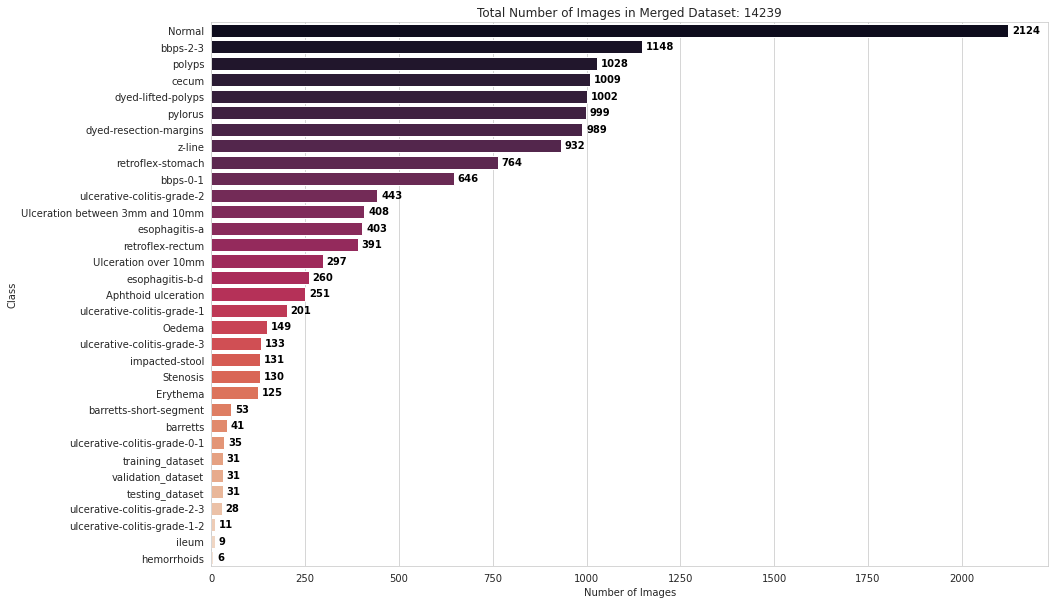

In [ ]:
# Create an empty dictionary to store the class counts
class_counts_before = {}

# Iterate through the merged directory and count the number of images per class
for directory in [merged_dir]:
    for category in os.listdir(directory):
        category_dir = os.path.join(directory, category)
        if os.path.isdir(category_dir) and os.listdir(category_dir):
            if category not in class_counts_before:
                class_counts_before[category] = 0
            class_counts_before[category] += len(os.listdir(category_dir))

# Convert class_counts dictionary into a pandas Series object and sort the values in descending order
class_counts_before_series = pd.Series(class_counts_before)
class_counts_before_sorted = class_counts_before_series.sort_values(ascending=False)

# Plot the number of images per class using seaborn
sns.set_style("whitegrid")
sns.barplot(x=class_counts_before_sorted.values, y=class_counts_before_sorted.index, palette="rocket")

# Set the plot labels
plt.title("Total Number of Images in Merged Dataset: {}".format(sum(class_counts_before.values())))
plt.ylabel("Class")
plt.xlabel("Number of Images")

# Add totals to the plot
for i, v in enumerate(class_counts_before_sorted.values):
    plt.text(v + 10, i + .15, str(v), color='black', fontweight='bold')

# Adjust the plot size
fig = plt.gcf()
fig.set_size_inches(15,10)

plt.show()

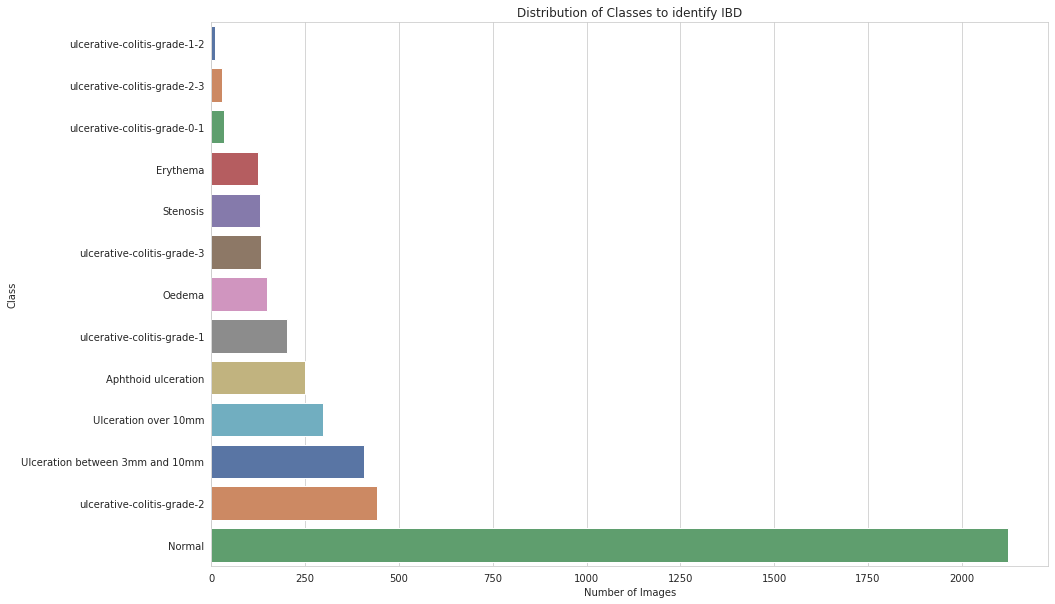

In [ ]:
# Get the value counts of the labels
label_counts = merged_labels['label'].value_counts()

# Sort the labels by count in ascending order
sorted_labels = label_counts.sort_values().index

# Set the color palette
colors = sns.color_palette("deep", len(label_counts))

# Create the bar plot
fig, ax = plt.subplots(figsize=(15,10))
sns.set_style("whitegrid")
sns.barplot(x=label_counts[sorted_labels], y=sorted_labels, palette=colors)

# Set the labels and title
plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.title('Distribution of Classes to identify IBD')

plt.show()


Using a pie chart to display the class distribution of the unique classes of Crohns, Ulcerative Colitis and Normal when making the predictions later using our model 

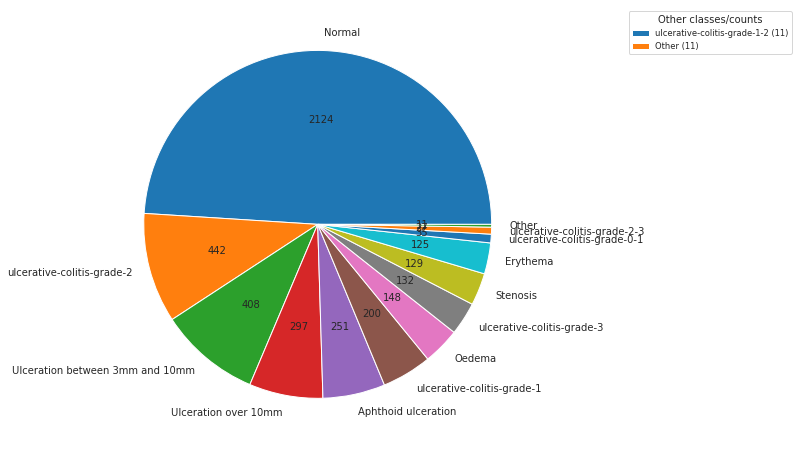

In [ ]:
# Get the value counts of the labels
label_counts = merged_labels['label'].value_counts()

# Define a threshold below which labels will be grouped into an "other" category
threshold = 25.0

# Group labels with counts below the threshold into an "other" category
other_count = label_counts[label_counts < threshold].sum()
other_labels = label_counts[label_counts < threshold].index
label_counts = label_counts[label_counts >= threshold]
label_counts['Other'] = other_count

# Create the pie chart
fig, ax = plt.subplots(figsize=(10,8))
ax.pie(label_counts, labels=label_counts.index, autopct=lambda pct: f"{int(pct/100.*sum(label_counts))}", textprops={'fontsize': 10})


# Add a legend for the small counts
if other_count > 0:
    legend_labels = [f"{label} ({count})" for label, count in zip(other_labels, merged_labels['label'].value_counts()[other_labels])]
    legend_labels.append(f"Other ({other_count})")
    ax.legend(legend_labels, title='Other classes/counts', loc='upper right', bbox_to_anchor=(1.6, 1.0), fontsize='small')

plt.show()

To explore the relationship between the class label and the part of the organ (upper or lower GI). This could us understand if there are any patterns or differences in the types of findings that occur in different parts of the GI tract, or whether certain types of findings tend to be classified differently. 

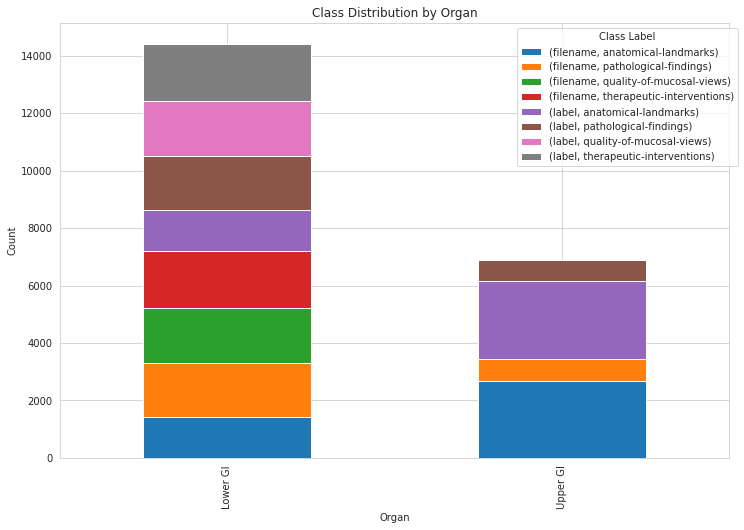

In [ ]:
# Create a pivot table of the class label by organ part
pivot_table = pd.pivot_table(data=dataset1_labels, index='Organ', columns='Classification', aggfunc=len)

# Create a stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(12,8))

# Set plot properties
plt.title('Class Distribution by Organ')
plt.xlabel('Organ')
plt.ylabel('Count')
plt.legend(title='Class Label')

# Move the legend to the upper right corner
plt.legend(title='Class Label', bbox_to_anchor=(1.02, 1), loc='upper right')


A boxplot is a way of summarizing and visualizing the distribution of a dataset. It displays the median, quartiles, and outliers of a dataset in a compact manner. A boxplot consists of a rectangular box, which represents the interquartile range (IQR) of the dataset, with the median shown as a line inside the box. The whiskers extend from the box to show the range of the data, excluding outliers, which are shown as individual points outside the whiskers.

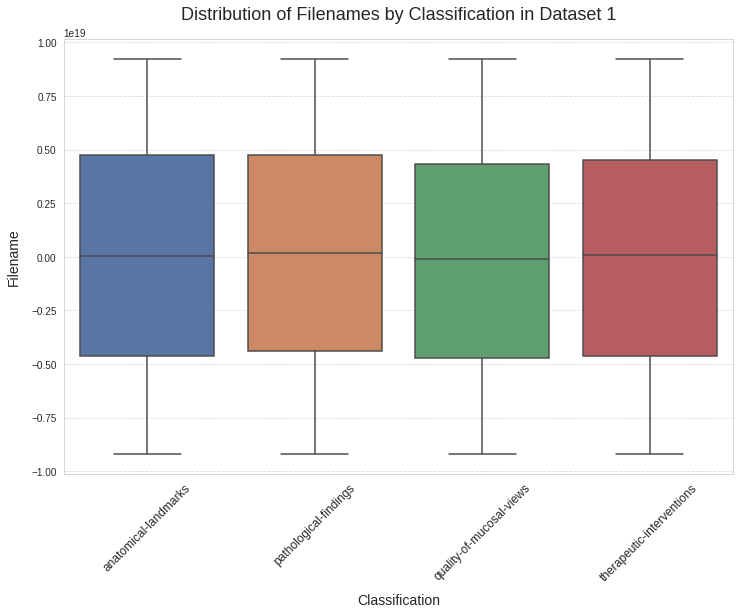

In [ ]:
# Convert filenames to integers
dataset1_labels['filename_int'] = dataset1_labels['filename'].apply(hash)

# Set the figure size and adjust the plot layout
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create a box plot of filename by classification
sns.boxplot(x='Classification', y='filename_int', data=dataset1_labels, showfliers=False)

# Add labels and title
plt.xlabel('Classification', fontsize=14, labelpad=10)
plt.ylabel('Filename', fontsize=14, labelpad=10)
plt.title('Distribution of Filenames by Classification in Dataset 1', fontsize=18, pad=20)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a background color to the plot
plt.style.use('seaborn-white')

# Remove the filename_int column
dataset1_labels = dataset1_labels.drop(columns=['filename_int'])

For dataset2, you could explore the relationship between the label and the filename, to see if there are any patterns in the way filenames are assigned to different labels. You could also explore the distribution of labels, to see if certain labels are more common or less common than others.

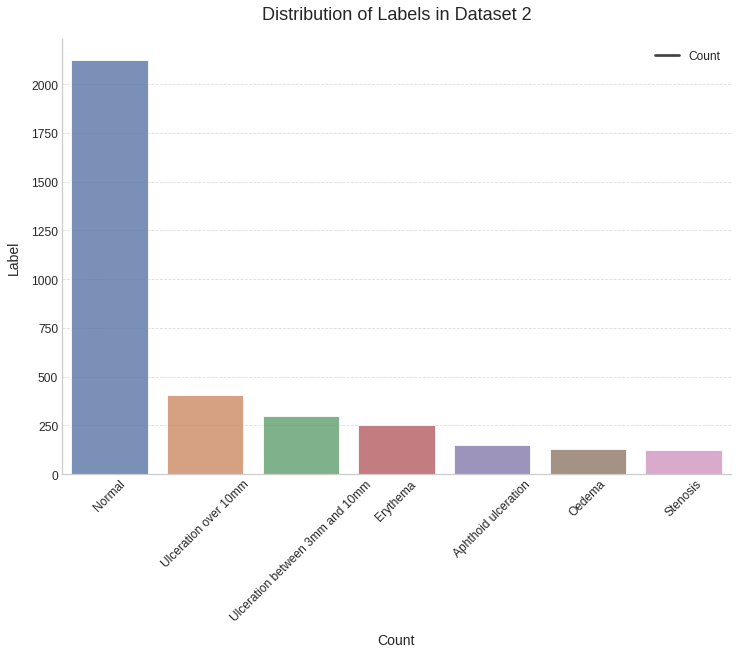

In [ ]:
# Set the size of the figure and adjust the plot layout
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.set_palette("deep")

# Plot the countplot using a vertical bar chart
sns.barplot(x=dataset2_labels['label'].unique(), y=dataset2_labels['label'].value_counts(), alpha=0.8)

# Add labels and title
plt.xlabel('Count', fontsize=14, labelpad=10)
plt.ylabel('Label', fontsize=14, labelpad=10)
plt.title('Distribution of Labels in Dataset 2', fontsize=18, pad=20)

# Add a legend and remove the top and right spines
plt.legend(['Count'], loc='upper right', fontsize=12)
sns.despine(top=True, right=True)

# Adjust the tick labels and grid lines
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a background color to the plot
plt.style.use('seaborn-white')

In [ ]:
# Create empty list to store the intensity values for each image
intensity_values_list = []

# Set up GPU acceleration using CuPy
import cupy as cp
cp.cuda.Device(0).use()  # Use GPU 0 for acceleration

# Loop through each row in the DataFrame
for index, row in merged_df.iterrows():

    # Load the image from the filepath
    img = Image.open(row['file_path'])

    # Convert the image to a CuPy array for GPU acceleration
    img_array = cp.asarray(img)

    # Flatten the array to create a 1D array of intensity values
    intensity_values = img_array.reshape(-1)

    # Convert the intensity values back to a NumPy array for storage
    intensity_values = cp.asnumpy(intensity_values)

    # Append the intensity values to the corresponding list
    intensity_values_list.append(intensity_values)

    # Show a progress bar to estimate remaining time
    if index % 1000 == 0:
        print(f'Processed {index} images out of {len(merged_df)}.')

# Convert the list to a NumPy array and add it to the DataFrame
merged_df['intensity_values'] = np.array(intensity_values_list)

# and save it with the new column for intensity values 
merged_df.to_csv('/content/drive/MyDrive/Final_Project/merged_data_intensity.csv', index=False)

Processed 0 images out of 14146.


UnidentifiedImageError: ignored

In [ ]:
df = pd.read_csv(merged_csv)

NameError: ignored

In [ ]:
merged_df

file_path  \
0      /content/drive/MyDrive/Final_Project/merged_di...   
1      /content/drive/MyDrive/Final_Project/merged_di...   
2      /content/drive/MyDrive/Final_Project/merged_di...   
3      /content/drive/MyDrive/Final_Project/merged_di...   
4      /content/drive/MyDrive/Final_Project/merged_di...   
...                                                  ...   
14141  /content/drive/MyDrive/Final_Project/merged_di...   
14142  /content/drive/MyDrive/Final_Project/merged_di...   
14143  /content/drive/MyDrive/Final_Project/merged_di...   
14144  /content/drive/MyDrive/Final_Project/merged_di...   
14145  /content/drive/MyDrive/Final_Project/merged_di...   

                            label  
0      ulcerative-colitis-grade-1  
1      ulcerative-colitis-grade-1  
2      ulcerative-colitis-grade-1  
3      ulcerative-colitis-grade-1  
4      ulcerative-colitis-grade-1  
...                           ...  
14141                      Normal  
14142                      Normal  
14143                      Normal  
14144                      Normal  
14145                      Normal  

[14146 rows x 2 columns]

In [ ]:
merged_df

file_path  \
0      /content/drive/MyDrive/Final_Project/merged_di...   
1      /content/drive/MyDrive/Final_Project/merged_di...   
2      /content/drive/MyDrive/Final_Project/merged_di...   
3      /content/drive/MyDrive/Final_Project/merged_di...   
4      /content/drive/MyDrive/Final_Project/merged_di...   
...                                                  ...   
14141  /content/drive/MyDrive/Final_Project/merged_di...   
14142  /content/drive/MyDrive/Final_Project/merged_di...   
14143  /content/drive/MyDrive/Final_Project/merged_di...   
14144  /content/drive/MyDrive/Final_Project/merged_di...   
14145  /content/drive/MyDrive/Final_Project/merged_di...   

                            label   intensity_values  
0      ulcerative-colitis-grade-1  [5 5 5 ... 1 3 2]  
1      ulcerative-colitis-grade-1  [4 4 4 ... 1 1 1]  
2      ulcerative-colitis-grade-1  [2 2 2 ... 0 0 0]  
3      ulcerative-colitis-grade-1  [2 2 2 ... 0 0 0]  
4      ulcerative-colitis-grade-1  [4 5 0 ... 2 2 2]  
...                           ...                ...  
14141                      Normal  [0 0 0 ... 0 0 0]  
14142                      Normal  [0 0 0 ... 0 0 0]  
14143                      Normal  [0 0 0 ... 0 0 0]  
14144                      Normal  [0 0 0 ... 0 0 0]  
14145                      Normal  [0 0 0 ... 0 0 0]  

[14146 rows x 3 columns]

using all the classes during training can help improve the robustness and generalizability of the model. I will include all the classes during training, but still only focus on the Crohn's, UC, and normal labels during prediction.

To do this, I will train a multi-class classifier that can predict all the classes in the dataset. During prediction, I will obtain the predicted probabilities for each class and use these probabilities to assign the image to Crohn's, UC, or normal based on a threshold. For example, if the predicted probability for Crohn's is greater than 0.5 and the predicted probability for UC and normal are less than 0.25, then I can assign the image to the Crohn's class.

Alternatively, I can train three separate binary classifiers, one for each label (Crohn's, UC, and normal). Each binary classifier will predict whether an image belongs to that label or not. During prediction, I can obtain the predicted probabilities for each binary classifier and use these probabilities to assign the image to the corresponding label based on a threshold. For example, if the predicted probability for Crohn's is greater than 0.5 and the predicted probabilities for UC and normal are less than 0.5, I can assign the image to the Crohn's label.

Using a multi-class classifier can be simpler to implement and requires fewer models to train. However, it may not be as accurate as using separate binary classifiers since it has to learn to distinguish between more classes. Additionally, it may be harder to interpret which features are important for each individual label.

Using separate binary classifiers can be more accurate since each model only has to distinguish between two classes (the label of interest and all the other classes combined). However, it requires training and evaluating multiple models, which can be more time-consuming and computationally intensive. Additionally, it may be harder to handle cases where an image belongs to multiple labels (e.g., Crohn's and UC).

In [ ]:
num_images = len(merged_df['file_path'])

print("Total number of images:", num_images)

Total number of images: 14146


In [ ]:
train_dir = '/content/drive/MyDrive/Final_Project/merged_dir/training_dataset'
val_dir = '/content/drive/MyDrive/Final_Project/merged_dir/validation_dataset'
test_dir = '/content/drive/MyDrive/Final_Project/merged_dir/testing_dataset'
aug_dir = '/content/drive/MyDrive/Final_Project/aug_dir'

os.makedirs(aug_dir, exist_ok=True)

In [ ]:
# split merged dataset into training, validation and testing sets
images = []
labels = []
for category in os.listdir(merged_dir):  # check if it's a directory before trying to list its contents 
  if os.path.isdir(os.path.join(merged_dir, category)):   
    for filename in os.listdir(os.path.join(merged_dir, category)):  
      images.append(os.path.join(merged_dir, category, filename))
      labels.append(category)

This is a three-way data split, where the initial dataset is split into training, validation, and testing sets.

The first train_test_split splits the data into a training set and a test set, where 30% of the data is reserved for testing. The stratify parameter ensures that the split is done in a way that preserves the class distribution of the original dataset.

The second train_test_split further splits the test set into a validation set and a new test set, where 50% of the remaining test data is assigned to the validation set, and the remaining 50% is assigned to the new test set. Again, the stratify parameter ensures that the class distribution is preserved in the splits.

In [ ]:
# Split the dataset into a 70:30 train-test split
train_images, test_images, train_labels, test_labels = train_test_split(images, 
                                                                        labels, 
                                                                        test_size=0.3, 
                                                                        random_state=42, 
                                                                        stratify=labels)

In [ ]:
# Split the test set into a 50:50 validation-test split
val_images, test_images, val_labels, test_labels = train_test_split(test_images,
                                                                    test_labels, 
                                                                    test_size=0.50,
                                                                    random_state=42,
                                                                    stratify=test_labels)

In [ ]:
# Print the sizes of the resulting splits
print("Number of images in train set:", len(train_images))
print("Number of images in validation set:", len(val_images))
print("Number of images in test set:", len(test_images))

Number of images in train set: 9971
Number of images in validation set: 2137
Number of images in test set: 2137


In [ ]:
# create directories for training, validation and testing sets
for category in os.listdir(merged_dir):
  os.makedirs(os.path.join(train_dir, category), exist_ok=True)
  os.makedirs(os.path.join(val_dir, category), exist_ok=True)
  os.makedirs(os.path.join(test_dir, category), exist_ok=True)
  os.makedirs(os.path.join(aug_dir), exist_ok=True)

In [ ]:
# Copy images to training, validation, and testing sets
for i, image in enumerate(train_images):
    category = train_labels[i]
    shutil.copy(image, os.path.join(train_dir, category, os.path.basename(image)))
for i, image in enumerate(val_images):
    category = val_labels[i]
    shutil.copy(image, os.path.join(val_dir, category, os.path.basename(image)))
for i, image in enumerate(test_images):
    category = test_labels[i]
    shutil.copy(image, os.path.join(test_dir, category, os.path.basename(image)))

IsADirectoryError: ignored

In [ ]:
print("Number of images per class in original merged dataset:")
total_merged = 0
for category in os.listdir(merged_dir):
    if os.path.isdir(os.path.join(merged_dir, category)):
        num_images = len(os.listdir(os.path.join(merged_dir, category)))
        total_merged += num_images
        print(f"{category}: {num_images}")
print(f"Total images in merged dataset: {total_merged}")

print("\nNumber of images per class in training set:")
total_train = 0
for category in os.listdir(train_dir):
    if os.path.isdir(os.path.join(train_dir, category)):
        num_images = len(os.listdir(os.path.join(train_dir, category)))
        total_train += num_images
        print(f"{category}: {num_images}")
print(f"Total images in training set: {total_train}")

print("\nNumber of images per class in validation set:")
total_val = 0
for category in os.listdir(val_dir):
    if os.path.isdir(os.path.join(val_dir, category)):
        num_images = len(os.listdir(os.path.join(val_dir, category)))
        total_val += num_images
        print(f"{category}: {num_images}")
print(f"Total images in validation set: {total_val}")

print("\nNumber of images per class in testing set:")
total_test = 0
for category in os.listdir(test_dir):
    if os.path.isdir(os.path.join(test_dir, category)):
        num_images = len(os.listdir(os.path.join(test_dir, category)))
        total_test += num_images
        print(f"{category}: {num_images}")
print(f"Total images in testing set: {total_test}")

Number of images per class in original merged dataset:
ulcerative-colitis-grade-1: 201
ulcerative-colitis-grade-3: 133
ulcerative-colitis-grade-1-2: 11
ulcerative-colitis-grade-0-1: 35
ulcerative-colitis-grade-2-3: 28
ulcerative-colitis-grade-2: 443
dyed-resection-margins: 989
dyed-lifted-polyps: 1002
hemorrhoids: 6
polyps: 1028
retroflex-rectum: 391
bbps-0-1: 646
barretts-short-segment: 53
cecum: 1009
esophagitis-b-d: 260
ileum: 9
barretts: 41
bbps-2-3: 1148
esophagitis-a: 403
impacted-stool: 131
pylorus: 999
z-line: 932
retroflex-stomach: 764
Aphthoid ulceration: 251
Erythema: 125
Oedema: 149
Stenosis: 130
Ulceration between 3mm and 10mm: 408
Ulceration over 10mm: 297
Normal: 2124
training_dataset: 31
validation_dataset: 31
testing_dataset: 31
.ipynb_checkpoints: 0
Total images in merged dataset: 14239

Number of images per class in training set:
ulcerative-colitis-grade-1: 141
ulcerative-colitis-grade-3: 93
ulcerative-colitis-grade-1-2: 8
ulcerative-colitis-grade-0-1: 24
ulcerative-

## multi-class classifier using ResNet50 architecture with Keras:

In [ ]:
batch_size = 32
img_width = 224
img_height = 224
epochs = 50
thresholds = {'Crohn\'s': 0.5, 'UC': 0.25, 'Normal': 0.25}

In [ ]:
# Define cutout augmentation 
def cutout(img, pad_size):
    h, w, c = img.shape
    padded_img = np.pad(img, [(pad_size, pad_size), (pad_size, pad_size), (0, 0)], mode='constant', constant_values=0)
    x = np.random.randint(pad_size, w + pad_size)
    y = np.random.randint(pad_size, h + pad_size)
    slice_x = slice(x - pad_size, x + pad_size + 1)
    slice_y = slice(y - pad_size, y + pad_size + 1)
    padded_img[slice_y, slice_x, :] = 0
    return padded_img[slice_y, slice_x, :]

Adjusting the values of alpha, sigma, rows, cols, and magnitude can control the degree and type of distortion applied to the images during augmentation.

 * alpha controls the strength of the distortion. 
Higher values of alpha lead to stronger distortion. A good starting point for alpha is around 50 and for sigma around 5.
 * sigma controls the standard deviation of the Gaussian filter used in the transformation. Higher values of sigma lead to a more blurred image.
 * rows and cols control the number of rows and columns in the grid used for the transformation. Higher values lead to a more fine-grained distortion. The larger the grid, the more pronounced the distortion effect will be. A good starting point is to set them to around 7-10
 * magnitude controls the magnitude of the distortion applied. Higher values of magnitude lead to a more intense distortion. A good starting point is around 0.2.
 * pad_size: This parameter controls the size of the square region that will be replaced by zeros in the cutout transformation. A good starting point is around 10-20.

Adjusting these parameters can allow you to fine-tune the level of distortion applied to the images during augmentation to achieve the desired level of variability without making the images too difficult for the model to learn from.

In [ ]:
def elastic_transform(image, alpha, sigma):
    shape = image.shape
    dx = np.random.randn(*shape) * sigma
    dy = np.random.randn(*shape) * sigma
    dz = np.zeros_like(dx)
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z+dz, (-1, 1))
    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [ ]:
def grid_distortion(image, rows, cols, magnitude):
    x, y = np.meshgrid(np.linspace(-1, 1, cols), np.linspace(-1, 1, rows))
    x_distortion = x + magnitude*np.random.normal(size=(rows, cols))
    y_distortion = y + magnitude*np.random.normal(size=(rows, cols))
    distortion_map = np.stack([x_distortion, y_distortion], axis=-1)
    return apply_transform(image, transform_matrix=distortion_map.reshape(-1, 2), channel_axis=2)

In [ ]:
def augment_image(image, alpha, sigma, rows, cols, magnitude, pad_size):
    # Apply elastic transform
    image = elastic_transform(image, alpha, sigma)
    
    # Apply grid distortion
    image = grid_distortion(image, rows, cols, magnitude)
    
    # Apply cutout
    image = cutout(image, pad_size)
    
    return image

In [ ]:
num_val_images = 0
for category in os.listdir(val_dir):
    if os.path.isdir(os.path.join(val_dir, category)):
        num_val_images += len(os.listdir(os.path.join(val_dir, category)))
print("Number of validation images:", num_val_images)

Number of validation images: 2122


In [ ]:
# params for augmented training data using the cutout, elastic transform and grid distortion functions
alpha = 50
sigma = 5
rows = 7
cols = 7
magnitude = 0.2
pad_size = 10

In [ ]:
# create data generators with CutOut, elastic transform and grid distortion for augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.0,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest',
                                   preprocessing_function=augment_image)

In [ ]:
# Create the ImageDataGenerators for the train, validation, and test datasets
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Final_Project/merged_dir/training_dataset', 
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size, 
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True,
                                                    classes=class_names,
                                                    save_to_dir='/content/drive/MyDrive/Final_Project/aug_dir')


test_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Final_Project/merged_dir/validation_dataset',
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  subset='validation',
                                                  shuffle=False, 
                                                  classes=class_names)



test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Final_Project/merged_dir/testing_dataset', 
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  classes=class_names)

num_val_samples = val_generator.n
print("number of validation samples: ", num_val_samples)

Found 9902 images belonging to 34 classes.
Found 0 images belonging to 34 classes.
Found 2122 images belonging to 34 classes.
number of validation samples:  0


In [ ]:
!ls -l /content/drive/MyDrive/Final_Project/merged_dir/validation_dataset


total 120
drwx------ 2 root root 4096 Mar 10 17:37 'Aphthoid ulceration'
drwx------ 2 root root 4096 Mar 10 17:37  barretts
drwx------ 2 root root 4096 Mar 10 17:37  barretts-short-segment
drwx------ 2 root root 4096 Mar 10 17:37  bbps-0-1
drwx------ 2 root root 4096 Mar 10 17:37  bbps-2-3
drwx------ 2 root root 4096 Mar 10 17:37  cecum
drwx------ 2 root root 4096 Mar 10 17:37  dyed-lifted-polyps
drwx------ 2 root root 4096 Mar 10 17:37  dyed-resection-margins
drwx------ 2 root root 4096 Mar 10 17:37  Erythema
drwx------ 2 root root 4096 Mar 10 17:37  esophagitis-a
drwx------ 2 root root 4096 Mar 10 17:37  esophagitis-b-d
drwx------ 2 root root 4096 Mar 10 17:37  hemorrhoids
drwx------ 2 root root 4096 Mar 10 17:37  ileum
drwx------ 2 root root 4096 Mar 10 17:37  impacted-stool
drwx------ 2 root root 4096 Mar 10 17:37  Normal
drwx------ 2 root root 4096 Mar 10 17:37  Oedema
drwx------ 2 root root 4096 Mar 10 17:37  polyps
drwx------ 2 root root 4096 Mar 10 17:37  pylorus
drwx------ 2 r

In [ ]:
print(val_generator.filenames)


[]


In [ ]:
import os
import re

val_dir = '/content/drive/MyDrive/Final_Project/merged_dir/validation_dataset'
for category in os.listdir(val_dir):
    if os.path.isdir(os.path.join(val_dir, category)):
        print(f"Category: {category}")
        for filename in os.listdir(os.path.join(val_dir, category)):
            print(f"\t{filename}")



Category: ulcerative-colitis-grade-1
	ulcerative-colitis-grade-1_304f4948-c4a1-4af8-bb05-1e186663acc1.jpg
	ulcerative-colitis-grade-1_15464c50-8c7d-4d6a-873e-c879466f2523.jpg
	ulcerative-colitis-grade-1_73d8da00-6017-4f77-8e7e-65bc9dd7d5db.jpg
	ulcerative-colitis-grade-1_e7f4a411-3cc9-4159-929c-ce73fd370e60.jpg
	ulcerative-colitis-grade-1_a773a269-2c3b-4e0f-b08b-6f38be28f459.jpg
	ulcerative-colitis-grade-1_0b952aa7-cbbd-44a2-9d0b-c31a46776aac.jpg
	ulcerative-colitis-grade-1_e463967a-0a42-4e41-a6f7-7b43b67b1cf0.jpg
	ulcerative-colitis-grade-1_4fd508ac-af98-4929-ba57-c66bc1696283.jpg
	ulcerative-colitis-grade-1_83663117-525e-4f59-81b3-9a7f1809b8e4.jpg
	ulcerative-colitis-grade-1_36bc0efb-776b-441c-a036-58f4bb2e9094.jpg
	ulcerative-colitis-grade-1_48d6d518-7979-4ffb-846e-a1c89b52bfaf.jpg
	ulcerative-colitis-grade-1_7ecf39fe-9e23-4e4d-8ec2-bbc6cf712414.jpg
	ulcerative-colitis-grade-1_243f7dce-db56-4dd9-b330-5e43ce7b8e80.jpg
	ulcerative-colitis-grade-1_e4d2ae73-8495-46e6-a121-8f3139effe64.j

In [ ]:
# Define regex pattern for filename format
pattern = r'[A-Za-z]+(\s[A-Za-z]+)*_[0-9]{5}\.jpg'

# Check each filename in the validation directory
for filename in os.listdir(train_dir):
    if re.match(pattern, filename) is None:
        print(f"Invalid filename format: {filename}")

Invalid filename format: ulcerative-colitis-grade-1
Invalid filename format: ulcerative-colitis-grade-3
Invalid filename format: ulcerative-colitis-grade-1-2
Invalid filename format: ulcerative-colitis-grade-0-1
Invalid filename format: ulcerative-colitis-grade-2-3
Invalid filename format: ulcerative-colitis-grade-2
Invalid filename format: dyed-resection-margins
Invalid filename format: dyed-lifted-polyps
Invalid filename format: hemorrhoids
Invalid filename format: polyps
Invalid filename format: retroflex-rectum
Invalid filename format: bbps-0-1
Invalid filename format: barretts-short-segment
Invalid filename format: cecum
Invalid filename format: esophagitis-b-d
Invalid filename format: ileum
Invalid filename format: barretts
Invalid filename format: bbps-2-3
Invalid filename format: esophagitis-a
Invalid filename format: impacted-stool
Invalid filename format: pylorus
Invalid filename format: z-line
Invalid filename format: retroflex-stomach
Invalid filename format: Aphthoid ulcer

In [ ]:
for root, dirs, files in os.walk(merged_dir):
    level = root.replace(merged_dir, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

Streaming output truncated to the last 5000 lines.
            Normal_01931.jpg
            Normal_03098.jpg
            Normal_00427.jpg
            Normal_02238.jpg
            Normal_01376.jpg
            Normal_01413.jpg
            Normal_02681.jpg
            Normal_00352.jpg
            Normal_00934.jpg
            Normal_02656.jpg
            Normal_01627.jpg
            Normal_02802.jpg
            Normal_02158.jpg
            Normal_01326.jpg
            Normal_02706.jpg
            Normal_02741.jpg
            Normal_01636.jpg
            Normal_02276.jpg
            Normal_01092.jpg
            Normal_02722.jpg
            Normal_02251.jpg
            Normal_02200.jpg
            Normal_02166.jpg
            Normal_02715.jpg
            Normal_02397.jpg
            Normal_02136.jpg
            Normal_01115.jpg
            Normal_02301.jpg
            Normal_02393.jpg
            Normal_00545.jpg
            Normal_03187.jpg
            Normal_03212.jpg
            Normal_02

In [ ]:
os.chdir('/content/drive/MyDrive/Final_Project/merged_dir')

In [ ]:
!pip install treelib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for treelib: filename=treelib-1.6.1-py3-none-any.whl size=18385 sha256=ccc5c1e4209ec586566b9605f3749b85ed9437e5c76bc256e62b207dc0892669
  Stored in directory: /root/.cache/pip/wheels/43/de/32/fd270cc5f06de2bebcdaa666e9350b95f54d983212a7aba9ad
Successfully built treelib


In [ ]:

from treelib import Node, Tree

dir_path = '/content/drive/MyDrive/Final_Project/merged_dir'
def print_directory_tree(dir_path):
    tree = Tree()
    tree.create_node(dir_path, dir_path)  # Create root node
    add_subdirectories_to_node(dir_path, tree, dir_path)
    tree.show()

def add_subdirectories_to_node(dir_path, tree, parent_node):
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        if os.path.isdir(file_path):
            node = tree.create_node(filename, file_path, parent=parent_node)
            add_subdirectories_to_node(file_path, tree, node)
        else:
            class_name = parent_node.identifier
            if class_name not in class_counts:
                class_counts[class_name] = 0
            class_counts[class_name] += 1
            if class_counts[class_name] <= 5:
                img = Image.open(file_path)
                print(f"Class: {class_name}, File: {filename}")
                display(img)

print_directory_tree('/content/drive/MyDrive/Final_Project/merged_dir')


/content/drive/MyDrive/Final_Project/merged_dir
├── .ipynb_checkpoints
├── Aphthoid ulceration
├── Erythema
├── Normal
├── Oedema
├── Stenosis
├── Ulceration between 3mm and 10mm
├── Ulceration over 10mm
├── barretts
├── barretts-short-segment
├── bbps-0-1
├── bbps-2-3
├── cecum
├── dyed-lifted-polyps
├── dyed-resection-margins
├── esophagitis-a
├── esophagitis-b-d
├── hemorrhoids
├── ileum
├── impacted-stool
├── polyps
├── pylorus
├── retroflex-rectum
├── retroflex-stomach
├── testing_dataset
│   ├── .ipynb_checkpoints
│   ├── Aphthoid ulceration
│   ├── Erythema
│   ├── Normal
│   ├── Oedema
│   ├── Stenosis
│   ├── Ulceration between 3mm and 10mm
│   ├── Ulceration over 10mm
│   ├── barretts
│   ├── barretts-short-segment
│   ├── bbps-0-1
│   ├── bbps-2-3
│   ├── cecum
│   ├── dyed-lifted-polyps
│   ├── dyed-resection-margins
│   ├── esophagitis-a
│   ├── esophagitis-b-d
│   ├── hemorrhoids
│   ├── ileum
│   ├── impacted-stool
│   ├── polyps
│   ├── pylorus
│   ├── retroflex-rectum


In [ ]:
# Get the class names from the directories
class_names = os.listdir(train_dir)

# Count the number of images per class in the merged dataset
class_counts_merged = {}
for category in class_names:
    category_dir = os.path.join(merged_dir, category)
    if os.path.isdir(category_dir) and os.listdir(category_dir):
        class_counts_merged[category] = len(os.listdir(category_dir))

# Convert class_counts_merged dictionary into a pandas Series object and sort the values in descending order
class_counts_merged_series = pd.Series(class_counts_merged)
class_counts_merged_sorted = class_counts_merged_series.sort_values(ascending=False)

# Print the number of images per class in the merged dataset
print("Number of images per class in the merged dataset:")
print(class_counts_merged_sorted)

# Count the number of images per class in the train, validation, and test sets
class_counts_split = {'Training': {}, 'Validation': {}, 'Testing': {}}
for set_name, directory in zip(class_counts_split.keys(), [train_dir, val_dir, test_dir]):
    for category in class_names:
        category_dir = os.path.join(directory, category)
        if os.path.isdir(category_dir) and os.listdir(category_dir):
            class_counts_split[set_name][category] = len(os.listdir(category_dir))

# Convert class_counts_split dictionary into a pandas DataFrame object and print the number of images per class
class_counts_split_df = pd.DataFrame(class_counts_split)
print("\nNumber of images per class in the train, validation, and test sets:")
print(class_counts_split_df)

# Count the number of images per class in the generator's output
class_counts_generator = {}
for category in class_names:
    generator_dir = os.path.join('/content/drive/MyDrive/Final_Project/aug_dir', category)
    if os.path.isdir(generator_dir) and os.listdir(generator_dir):
        class_counts_generator[category] = len(os.listdir(generator_dir))

# Convert class_counts_generator dictionary into a pandas Series object and sort the values in descending order
class_counts_generator_series = pd.Series(class_counts_generator)
class_counts_generator_sorted = class_counts_generator_series.sort_values(ascending=False)

# Print the number of images per class in the generator's output
print("\nNumber of images per class in the generator's output:")
print(class_counts_generator_sorted)

Number of images per class in the merged dataset:
Normal                             2124
bbps-2-3                           1148
polyps                             1028
cecum                              1009
dyed-lifted-polyps                 1002
pylorus                             999
dyed-resection-margins              989
z-line                              932
retroflex-stomach                   764
bbps-0-1                            646
ulcerative-colitis-grade-2          443
Ulceration between 3mm and 10mm     408
esophagitis-a                       403
retroflex-rectum                    391
Ulceration over 10mm                297
esophagitis-b-d                     260
Aphthoid ulceration                 251
ulcerative-colitis-grade-1          201
Oedema                              149
ulcerative-colitis-grade-3          133
impacted-stool                      131
Stenosis                            130
Erythema                            125
barretts-short-segment        

<ipython-input-129-3c015d9b278e>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  class_counts_generator_series = pd.Series(class_counts_generator)


In order to address the class imbalances, we have performed data augmentation. Let us check and see how much more data has been created through a visualisation

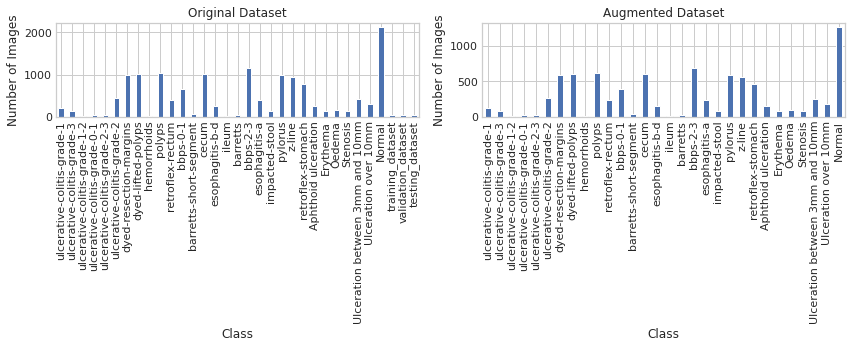

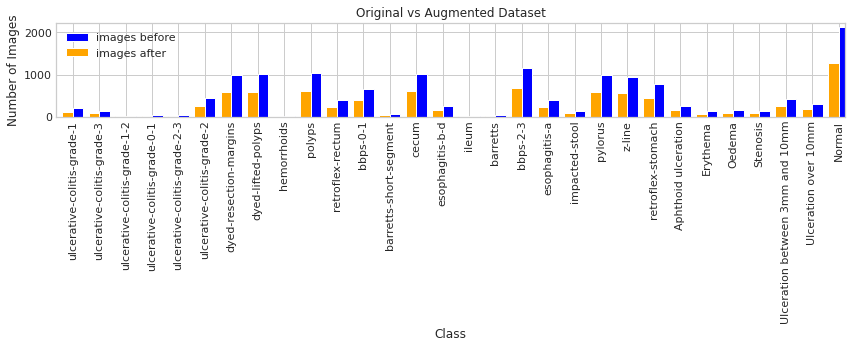

In [ ]:
class_counts_after = {}
for i in range(len(train_generator.filenames)):
    class_folder = train_generator.filenames[i].split('/')[0]
    if class_folder not in class_counts_after:
        class_counts_after[class_folder] = 0
    class_counts_after[class_folder] += 1

class_counts_after_series = pd.Series(class_counts_after)

# Plot bar charts for both original and augmented datasets
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
class_counts_before_series.plot(kind='bar', ax=axes[0])
axes[0].set_title('Original Dataset')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')
class_counts_after_series.plot(kind='bar', ax=axes[1])
axes[1].set_title('Augmented Dataset')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Images')
plt.tight_layout()
plt.show()

# Plot bar chart for both original and augmented datasets
fig, ax = plt.subplots(figsize=(12, 5))
class_counts_before_series.plot(kind='bar', ax=ax, position=0, width=0.4, label='images before', color='blue')
class_counts_after_series.plot(kind='bar', ax=ax, position=1, width=0.4, label='images after', color='orange')
ax.set_title('Original vs Augmented Dataset')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Load the dataset from directory
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=42,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=True,
                                                                 validation_split=0.2,
                                                                 subset="validation",
                                                                 seed=42,
                                                                 image_size=IMG_SIZE)

Found 9902 files belonging to 31 classes.
Using 7922 files for training.
Found 2122 files belonging to 31 classes.
Using 424 files for validation.


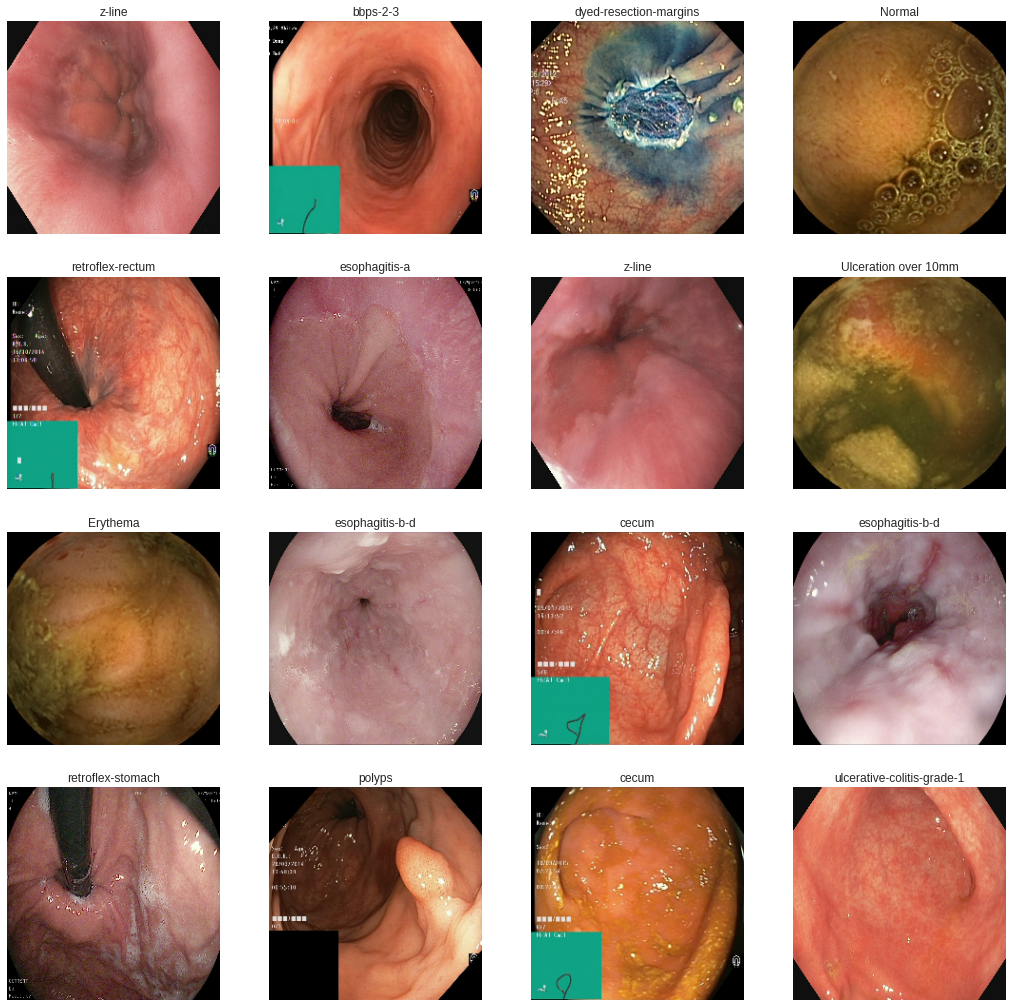

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(18, 18))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 10
Number of test batches: 4


The AUTOTUNE constant is a special value that allows TensorFlow to automatically determine the optimal buffer size at runtime. When using prefetching, TensorFlow will try to fetch batches of data from disk while your model is still training on the previous batch. This can significantly speed up the training process since your model won't have to wait for disk I/O.

prefetch(buffer_size=AUTOTUNE) is a method of the tf.data.Dataset class which adds a prefetching step to the dataset pipeline. This means that while the GPU is processing the current batch, the CPU will be fetching the next batch of data from disk, ensuring that there is always a steady stream of data being fed to the model. The buffer_size parameter determines how many elements should be prefetched at a time. The AUTOTUNE value allows TensorFlow to automatically determine the optimal buffer size at runtime based on available system resources.

By adding prefetching to the dataset pipeline, we can reduce the idle time of the GPU and improve overall training efficiency.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.3),
  tf.keras.layers.RandomBrightness([-0.8,0.8]),
  tf.keras.layers.RandomContrast(0.2)
])

In [ ]:
# Apply the data augmentation pipeline on-the-fly during training
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y),
                                  num_parallel_calls=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


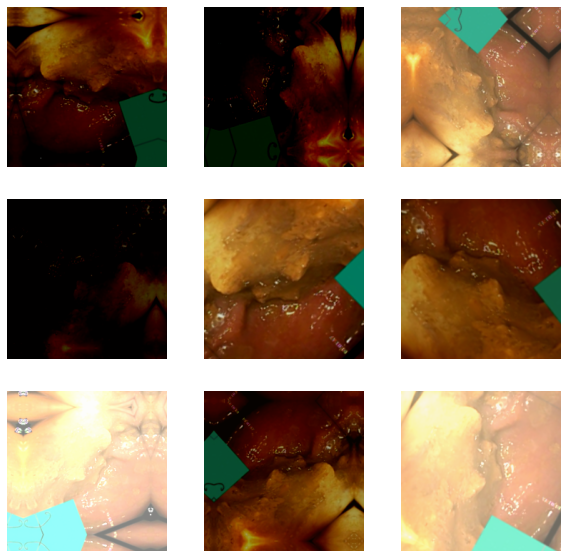

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0),training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Normalize the pixel values of the images
preprocess_input_resnet = tf.keras.applications.resnet50.preprocess_input
preprocess_input_inception = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
# Create the ResNet50 model
base_model = tf.keras.applications.ResNet50(weights='imagenet',
                                            include_top=False, 
                                            input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
print(len(class_names))

31


In [ ]:
# Get the number of unique labels in the training set
num_classes = len(class_names)

# Add the classification head to the base model
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224,224,3)),
        data_augmentation,
        tf.keras.layers.Lambda(preprocess_input_resnet),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        prediction_layer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 31)                63519     
                                                                 
Total params: 23,651,231
Trainable params: 63,519
Non-trainable params: 23,587,712
_____________________________________

In [ ]:
# Compile the model
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
print(train_dataset.element_spec)
print(validation_dataset.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
# Train the model

initial_epochs = 10

# Train the model
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    )


# Save the model
tf.saved_model.save(model, '/content/drive/MyDrive/Final_Project/Models/model_1.h5')

Epoch 1/10


248/248 [==============================] - 226s 846ms/step - loss: 2.5159 - accuracy: 0.3090 - val_loss: 1.7614 - val_accuracy: 0.4696
Epoch 2/10
248/248 [==============================] - 59s 235ms/step - loss: 1.6761 - accuracy: 0.5473 - val_loss: 1.2820 - val_accuracy: 0.6014
Epoch 3/10
248/248 [==============================] - 58s 234ms/step - loss: 1.4025 - accuracy: 0.6159 - val_loss: 1.1261 - val_accuracy: 0.6419
Epoch 4/10
248/248 [==============================] - 58s 231ms/step - loss: 1.2593 - accuracy: 0.6447 - val_loss: 1.0432 - val_accuracy: 0.6689
Epoch 5/10
248/248 [==============================] - 58s 230ms/step - loss: 1.1585 - accuracy: 0.6671 - val_loss: 0.9101 - val_accuracy: 0.7027
Epoch 6/10
248/248 [==============================] - 59s 236ms/step - loss: 1.0805 - accuracy: 0.6849 - val_loss: 0.8450 - val_accuracy: 0.7061
Epoch 7/10
248/248 [==============================] - 58s 231ms/step - loss: 1.0411 - accuracy: 0.6872 - val_loss: 0.8392 - val_accuracy: 0.

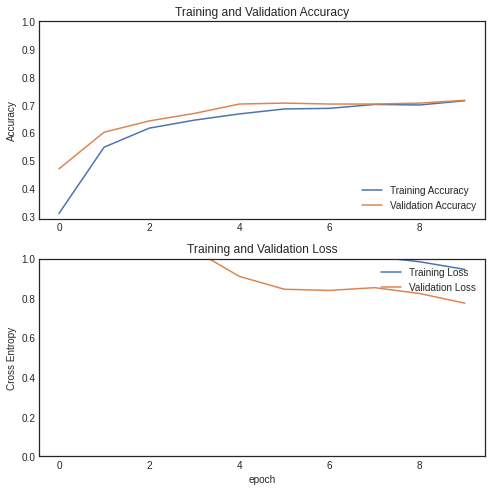

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning
 - unfreeze the base model and set the bottom layers to be untrainable

In [ ]:
base_model.trainable = True

In [ ]:
# How many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

# Save the model
tf.saved_model.save(model, '/content/drive/MyDrive/Final_Project/Models/model_2.h5')

Epoch 10/20


248/248 [==============================] - 81s 246ms/step - loss: 1.1056 - accuracy: 0.6640 - val_loss: 0.6449 - val_accuracy: 0.7432
Epoch 11/20
248/248 [==============================] - 60s 242ms/step - loss: 0.8541 - accuracy: 0.7252 - val_loss: 0.5772 - val_accuracy: 0.7669
Epoch 12/20
248/248 [==============================] - 60s 241ms/step - loss: 0.7976 - accuracy: 0.7454 - val_loss: 0.5838 - val_accuracy: 0.7838
Epoch 13/20
248/248 [==============================] - 60s 241ms/step - loss: 0.7277 - accuracy: 0.7632 - val_loss: 0.5450 - val_accuracy: 0.7804
Epoch 14/20
248/248 [==============================] - 60s 241ms/step - loss: 0.6772 - accuracy: 0.7884 - val_loss: 0.5172 - val_accuracy: 0.7973
Epoch 15/20
248/248 [==============================] - 60s 241ms/step - loss: 0.6267 - accuracy: 0.7973 - val_loss: 0.5253 - val_accuracy: 0.7905
Epoch 16/20
248/248 [==============================] - 60s 242ms/step - loss: 0.6298 - accuracy: 0.7929 - val_loss: 0.5254 - val_accurac

## Visualise the performance after some fine-tuning

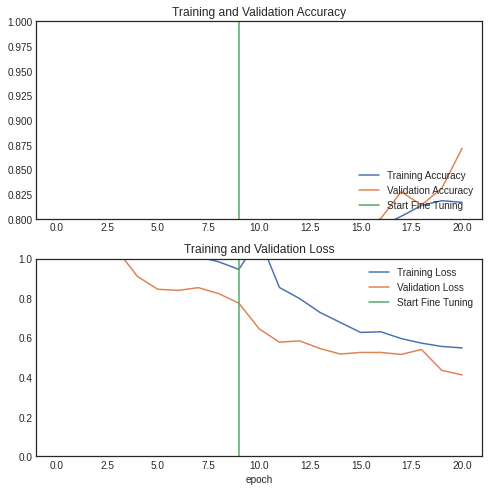

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and Prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 56ms/step - loss: 0.5031 - accuracy: 0.8359
Test accuracy : 0.8359375


In [ ]:
# Make predictions on test set
predictions = model.predict(test_dataset)

4/4 [==============================] - 2s 52ms/step


In [ ]:
# Load the saved model using tf.saved_model.load()
model = tf.saved_model.load('/content/drive/MyDrive/Final_Project/Models/model_2.h5')


Found 2122 files belonging to 31 classes.


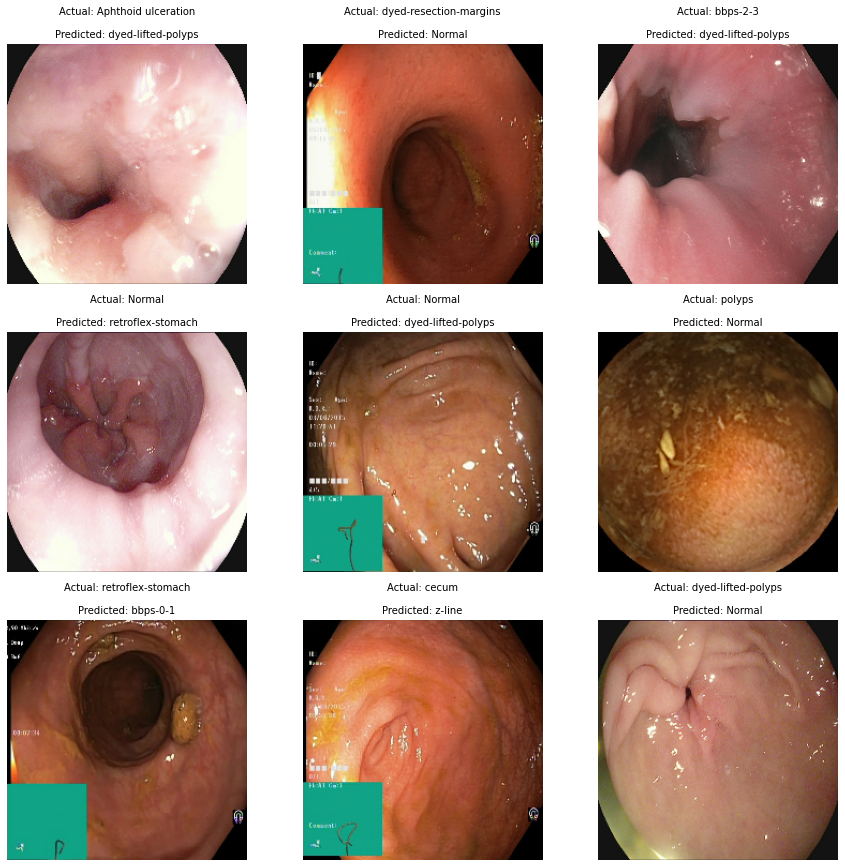

In [ ]:
import random

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Final_Project/merged_dir/testing_dataset',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    #seed=42,
    validation_split=None,
    subset=None,
    interpolation='bilinear'
)

# Make predictions on the test dataset
predictions = []
for batch in test_dataset:
    batch_inputs = batch[0]
    batch_predictions = model(batch_inputs)
    predictions.extend(batch_predictions.numpy())

# Get the predicted class for each image
class_names = test_dataset.class_names
predicted_classes = [class_names[np.argmax(prediction)] for prediction in predictions]

# Get a random selection of images from the test dataset
sample_images = random.sample(list(test_dataset), k=9)

# Get the actual class for each image
actual_classes = []
for image_batch, label_batch in test_dataset:
    for i in range(len(label_batch)):
        actual_classes.append(class_names[label_batch[i]])

# Plot the images with their actual and predicted labels
plt.figure(figsize=(15, 15))
for i in range(len(image_batch)):
  if i >= 9:
        break
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype('uint8'))
  if len(actual_classes) == len(predicted_classes):
      plt.title(f"Actual: {actual_classes[i]}\n\nPredicted: {predicted_classes[i]}", fontsize=10)
  else:
      plt.title(f"Predicted: {predicted_classes[i]}", fontsize=10)
  plt.axis('off')




## Classification Report

The classification report table summarizes the performance of a classification model on a given dataset. It shows various metrics for each class in the dataset, including precision, recall, and F1-score.

Precision is the fraction of true positives out of all predicted positive cases, while recall is the fraction of true positives out of all actual positive cases. F1-score is the harmonic mean of precision and recall.

The support column shows the number of samples for each class. The micro avg row shows the overall performance of the model, while the macro avg row shows the average performance across all classes. The weighted avg row shows the average performance weighted by the number of samples in each class.

In general, a good classification model should have high precision, recall, and F1-score for each class.

However, the results in the classification report suggest that the model has low precision, recall and F1-score for most of the classes. This indicates that the model is not performing well and is not able to correctly classify the different classes. It is possible that the model needs to be trained on more data or that the model architecture needs to be improved. Additionally, it is important to analyze the distribution of classes in the dataset to check for imbalances and take steps to address them if they exist.

In [ ]:
# Get the true labels for the test dataset
y_true = [class_names[label] for _, label in test_dataset.unbatch()]

# Generate the classification report
report = classification_report(y_true, predicted_classes, labels=class_names, target_names=class_names)


# Print the report
print(report)

                                 precision    recall  f1-score   support

             .ipynb_checkpoints       0.00      0.00      0.00         0
            Aphthoid ulceration       0.00      0.00      0.00        37
                       Erythema       0.00      0.00      0.00        19
                         Normal       0.17      0.20      0.19       318
                         Oedema       0.00      0.00      0.00        23
                       Stenosis       0.00      0.00      0.00        20
Ulceration between 3mm and 10mm       0.02      0.02      0.02        61
           Ulceration over 10mm       0.00      0.00      0.00        45
                       barretts       0.00      0.00      0.00         6
         barretts-short-segment       0.00      0.00      0.00         8
                       bbps-0-1       0.08      0.07      0.07        97
                       bbps-2-3       0.11      0.10      0.11       172
                          cecum       0.03      0.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

## Observation from the classification report: 

The warning message "Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use zero_division parameter to control this behavior." indicates that some of the classes in the dataset have no predicted samples. This could mean that the model is not able to effectively classify those classes due to various reasons such as lack of data or imbalanced data.

The implication of setting zero_division parameter to True is that the precision and F-score will be set to 0 for those classes with no predicted samples. This means that the model is not able to classify those classes effectively and it may require further tuning or improvement. On the other hand, if zero_division parameter is set to False, then the warning will be raised again and the precision and F-score will not be calculated for those classes with no predicted samples. It is important to note that this decision should be based on the specific problem and the requirements of the task at hand.

# InceptionV3

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False, 
    input_shape=(224, 224, 3))

base_model.trainable=False

model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224,224,3)),
        data_augmentation,
        tf.keras.layers.Lambda(preprocess_input_inception),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        prediction_layer])

model.summary()

87910968/87910968 [==============================] - 1s 0us/step


NameError: ignored

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# Save the model
tf.saved_model.save(model, '/content/drive/MyDrive/Final_Project/Models/model_3.h5')

Epoch 1/10


248/248 [==============================] - 68s 234ms/step - loss: 2.7632 - accuracy: 0.2270 - val_loss: 2.1511 - val_accuracy: 0.4392
Epoch 2/10
248/248 [==============================] - 56s 225ms/step - loss: 2.0873 - accuracy: 0.4289 - val_loss: 1.8098 - val_accuracy: 0.4831
Epoch 3/10
248/248 [==============================] - 56s 225ms/step - loss: 1.7942 - accuracy: 0.5008 - val_loss: 1.5110 - val_accuracy: 0.5405
Epoch 4/10
248/248 [==============================] - 57s 227ms/step - loss: 1.6292 - accuracy: 0.5437 - val_loss: 1.4293 - val_accuracy: 0.5642
Epoch 5/10
248/248 [==============================] - 56s 225ms/step - loss: 1.5315 - accuracy: 0.5689 - val_loss: 1.2900 - val_accuracy: 0.6318
Epoch 6/10
248/248 [==============================] - 56s 224ms/step - loss: 1.4445 - accuracy: 0.5848 - val_loss: 1.2911 - val_accuracy: 0.6115
Epoch 7/10
248/248 [==============================] - 56s 224ms/step - loss: 1.3857 - accuracy: 0.5968 - val_loss: 1.1889 - val_accuracy: 0.6

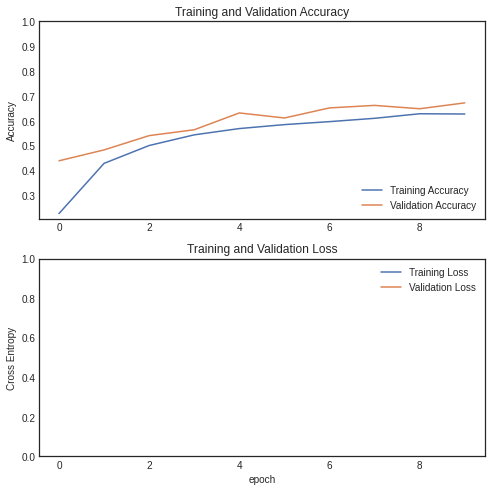

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# How many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


## Compile and continue training the model

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

# Save the model
tf.saved_model.save(model, '/content/drive/MyDrive/Final_Project/Models/model_4.h5')

Epoch 10/20


248/248 [==============================] - 96s 269ms/step - loss: 1.6208 - accuracy: 0.5516 - val_loss: 0.9608 - val_accuracy: 0.7027
Epoch 11/20
248/248 [==============================] - 66s 265ms/step - loss: 1.1446 - accuracy: 0.6679 - val_loss: 0.7428 - val_accuracy: 0.7331
Epoch 12/20
248/248 [==============================] - 65s 261ms/step - loss: 0.9796 - accuracy: 0.6999 - val_loss: 0.6715 - val_accuracy: 0.7635
Epoch 13/20
248/248 [==============================] - 65s 261ms/step - loss: 0.8890 - accuracy: 0.7190 - val_loss: 0.6733 - val_accuracy: 0.7703
Epoch 14/20
248/248 [==============================] - 65s 260ms/step - loss: 0.8226 - accuracy: 0.7410 - val_loss: 0.6063 - val_accuracy: 0.8041
Epoch 15/20
248/248 [==============================] - 65s 261ms/step - loss: 0.7618 - accuracy: 0.7616 - val_loss: 0.5975 - val_accuracy: 0.7905
Epoch 16/20
248/248 [==============================] - 65s 260ms/step - loss: 0.7352 - accuracy: 0.7614 - val_loss: 0.5190 - val_accurac

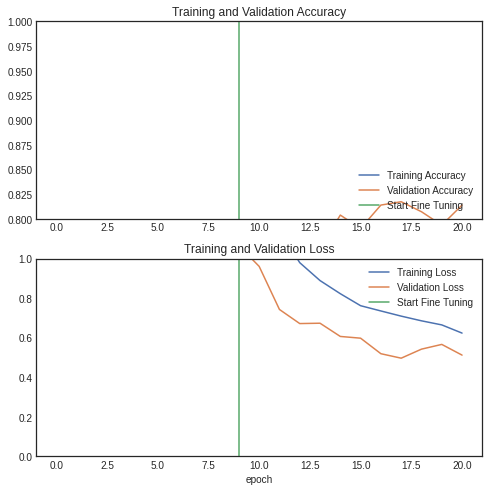

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## load the model and continue training past 20 epochs 


In [ ]:
# Load the saved model using tf.saved_model.load()
model = tf.saved_model.load('/content/drive/MyDrive/Final_Project/Models/model_4.h5')

Found 2122 files belonging to 31 classes.


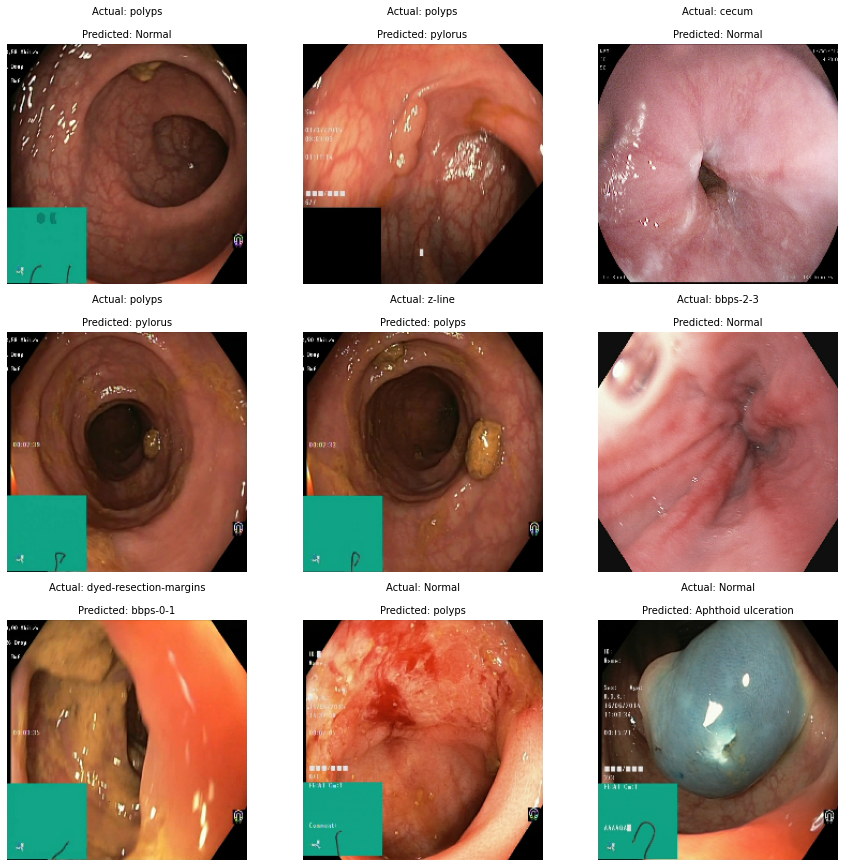

In [ ]:
import random

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Final_Project/merged_dir/testing_dataset',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None
)

# Make predictions on the test dataset
predictions = []
for batch in test_dataset:
    batch_inputs = batch[0]
    batch_predictions = model(batch_inputs)
    predictions.extend(batch_predictions.numpy())

# Get the predicted class for each image
class_names = test_dataset.class_names
predicted_classes = [class_names[np.argmax(prediction)] for prediction in predictions]

# Get a random selection of images from the test dataset
sample_images = random.sample(list(test_dataset), k=9)

# Get the actual class for each image
actual_classes = []
for image_batch, label_batch in test_dataset:
    for i in range(len(label_batch)):
        actual_classes.append(class_names[label_batch[i]])

# Plot the images with their actual and predicted labels
plt.figure(figsize=(15, 15))
for i in range(len(image_batch)):
  if i >= 9:
        break
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype('uint8'))
  if len(actual_classes) == len(predicted_classes):
      plt.title(f"Actual: {actual_classes[i]}\n\nPredicted: {predicted_classes[i]}", fontsize=10)
  else:
      plt.title(f"Predicted: {predicted_classes[i]}", fontsize=10)
  plt.axis('off')

## Classification Report

The classification report table summarizes the performance of a classification model on a given dataset. It shows various metrics for each class in the dataset, including precision, recall, and F1-score.

Precision is the fraction of true positives out of all predicted positive cases, while recall is the fraction of true positives out of all actual positive cases. F1-score is the harmonic mean of precision and recall.

The support column shows the number of samples for each class. The micro avg row shows the overall performance of the model, while the macro avg row shows the average performance across all classes. The weighted avg row shows the average performance weighted by the number of samples in each class.

In general, a good classification model should have high precision, recall, and F1-score for each class. 

However, the results in the classification report suggest that the model has low precision, recall and F1-score for most of the classes. This indicates that the model is not performing well and is not able to correctly classify the different classes. It is possible that the model needs to be trained on more data or that the model architecture needs to be improved. Additionally, it is important to analyze the distribution of classes in the dataset to check for imbalances and take steps to address them if they exist.

In [ ]:
# Get the true labels for the test dataset
y_true = [class_names[label] for _, label in test_dataset.unbatch()]

# Generate the classification report
report = classification_report(y_true, predicted_classes, labels=class_names, target_names=class_names)


# Print the report
print(report)

                                 precision    recall  f1-score   support

             .ipynb_checkpoints       0.00      0.00      0.00         0
            Aphthoid ulceration       0.03      0.03      0.03        37
                       Erythema       0.00      0.00      0.00        19
                         Normal       0.16      0.18      0.17       318
                         Oedema       0.00      0.00      0.00        23
                       Stenosis       0.00      0.00      0.00        20
Ulceration between 3mm and 10mm       0.03      0.03      0.03        61
           Ulceration over 10mm       0.03      0.02      0.03        45
                       barretts       0.00      0.00      0.00         6
         barretts-short-segment       0.00      0.00      0.00         8
                       bbps-0-1       0.04      0.04      0.04        97
                       bbps-2-3       0.07      0.08      0.07       172
                          cecum       0.09      0.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
print(set(actual_classes) - set(class_names))


set()


In [ ]:
missing_classes = set(actual_classes) - set(class_names)
print(missing_classes)


set()


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


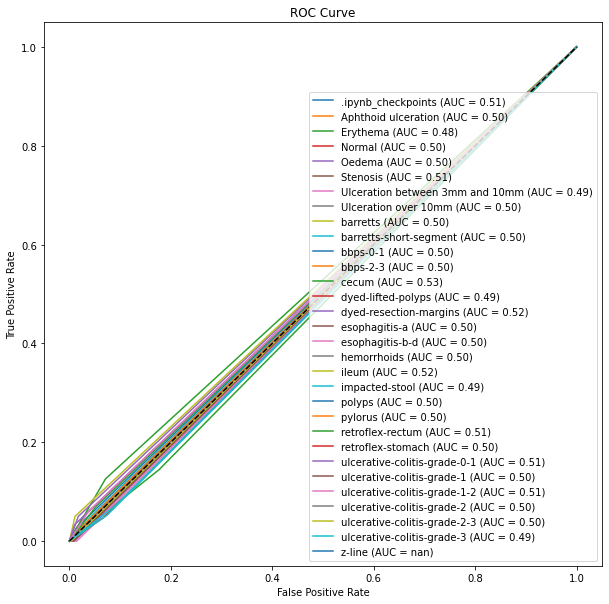

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Get the actual class for each image and encode the class names to integers
label_encoder = LabelEncoder()
actual_classes = []
for image_batch, label_batch in test_dataset:
    for i in range(len(label_batch)):
        actual_classes.append(label_batch[i])
encoded_actual_classes = label_encoder.fit_transform(actual_classes)

# Convert the predicted class labels to integers using the label_encoder
encoded_predicted_classes = label_encoder.transform(predicted_classes)

# Convert the actual and predicted class labels to one-hot encoded vectors
y_true = tf.keras.utils.to_categorical(encoded_actual_classes, num_classes=len(class_names))
y_pred = tf.keras.utils.to_categorical(encoded_predicted_classes, num_classes=len(class_names))

# Compute the ROC curve and AUC score for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()

## Observation on the above graph: 

This warning message is telling us that there are no positive samples in the true labels (y_true) for a particular class. This can happen if the dataset is imbalanced and some classes have very few samples or if the model is not able to correctly predict any samples for a particular class.

To address this, we can try the following:

Check the distribution of the classes in your dataset to see if there are any imbalances using np.bincount(y_true) to get the number of samples for each class.

If there are imbalances, we can try to use techniques like oversampling or undersampling to balance the dataset.

We can also try to retrain the model with a different set of hyperparameters or try a different model architecture.


In [ ]:
# Get the actual class for each image
actual_classes = []
for image_batch, label_batch in test_dataset:
    for i in range(len(label_batch)):
        actual_classes.append(label_batch[i])

# Count the number of samples for each class
class_counts = np.bincount(actual_classes)
print(class_counts)

[  0  37  19 318  23  20  61  45   6   8  97 172 151 151 149  60  39   1
   1  20 154 150  58 115   5  30   1  67   4  20 140]


This result shows the number of samples for each class in the dataset.

For example, the first class has 0 samples, the second class has 37 samples, the third class has 19 samples, and so on.

You can see that there are some classes with very few samples, like the first and last classes which have 0 and 1 samples respectively, and there are some classes with many more samples, like the 4th class which has 318 samples. This indicates that there may be class imbalance in the dataset, which could affect the performance of the model.